# Pandas

The foundation of most python work done at the CER. Pandas is kind of a combination between excel and SQL

The first step in Pandas is often to read in our dataset into a DataFrame object. This could come from a CSV, excel file, any database, dictionary (JSON), or many other data formats.


- Pandas I/O
- DataFrame object


First step: Import pandas. We can give a custom name to all our imports. "pd" is the common convention you will see everywhere. All the pandas functionality will be contained in the "pd" object

In [166]:
import pandas as pd
import dateutil.relativedelta as relativedelta

In [167]:
df = pd.read_excel('2020lqdptrlmgs.xlsx',sheet_name = 'Data') #read from a saved dataset

In [168]:
type(df)

pandas.core.frame.DataFrame

In [169]:
df.head()

,Region / Région,Date,Spec. propane / propane pur,Total butane / butane - total,Normal butane / butane normal,Iso-butane,Total mix / mélange - total,C2 in mix / mélange - C2,C3 in mix / mélange - C3,C4 in mix / mélange - C4,Other in mix / mélange - autres
0,Canada,2000-01-01,784.036998,362.449492,NaN,NaN,399.786525,0.000000,194.177107,148.029764,57.579654
1,Canada,2000-02-01,356.524189,227.550475,NaN,NaN,383.860440,0.000000,181.748400,140.397040,61.715000
2,Canada,2000-03-01,173.564615,138.456572,NaN,NaN,321.312165,0.015462,155.674621,122.755902,42.866180
3,Canada,2000-04-01,297.382941,214.332134,NaN,NaN,384.313830,42.537402,185.803634,122.041656,33.931138
4,Canada,2000-05-01,596.065626,355.837875,NaN,NaN,369.390836,32.269491,180.196321,121.011815,35.913209


## DataFrame from SQL

In [170]:
from sqlalchemy import create_engine
from sqlalchemy import MetaData
import sqlalchemy
#%%

def cer_connection():
    conn_str = 'enter database connection string'
    engine = create_engine(conn_str)
    conn = engine.connect()
    return(conn,engine)


In [171]:
try:
    conn, engine = cer_connection()
    dfsql = pd.read_sql_query('select top (10) * from BakerHughes_Detailed',con=conn)
    dfsql.head()
except:
    print('cant connect to database!')

cant connect to database!


In [172]:
query = "SELECT \
[PublishDate], \
year([PublishDate]) as [Year], \
month([PublishDate]) as [Month], \
DATEPART( wk, [PublishDate]) as [Week], \
[Country], \
[DrillFor], \
sum([RigCount]) as [RigCount] \
\
FROM [EnergyData].[dbo].[BakerHughes_Detailed] \
where Country = 'CANADA' and DrillFor = 'Oil'\
\
group by PublishDate, Country, DrillFor"

In [173]:
try: 
    dfsql = pd.read_sql_query(query,con=conn)
    dfsql.head()
    conn.close()
except:
    print('cant connect to database!')

cant connect to database!


Should you have raw connection strings, passwords, and API keys directly in your code?

In [174]:
import json
def open_connection_string(file_name='connection.json'):
    with open(file_name) as json_file:
        data = json.load(json_file)
    return data['conn_str']

try:
    open_connection_string()
except:
    print('cant open json file!')

In [175]:
df.shape #(rows,columns)

(738, 11)

## DataFrame columns

In [176]:
df.columns

Index(['Region / Région', 'Date', 'Spec. propane / propane pur',
       'Total butane / butane - total', 'Normal butane / butane normal',
       'Iso-butane', 'Total mix / mélange - total', 'C2 in mix / mélange - C2',
       'C3 in mix / mélange - C3', 'C4 in mix / mélange - C4',
       'Other in mix / mélange - autres'],
      dtype='object')

In [177]:
def english_only(col_names):
    #TODO: Remove periods and make columns lowercase
    return {x:x.split('/')[0].strip() for x in col_names}

In [178]:
new_columns = english_only(df.columns)
new_columns

{'Region / Région': 'Region',
 'Date': 'Date',
 'Spec. propane / propane pur': 'Spec. propane',
 'Total butane / butane - total': 'Total butane',
 'Normal butane / butane normal': 'Normal butane',
 'Iso-butane': 'Iso-butane',
 'Total mix / mélange - total': 'Total mix',
 'C2 in mix / mélange - C2': 'C2 in mix',
 'C3 in mix / mélange - C3': 'C3 in mix',
 'C4 in mix / mélange - C4': 'C4 in mix',
 'Other in mix / mélange - autres': 'Other in mix'}

In [179]:
df = df.rename(columns=new_columns)
#same as:
#df.rename(columns=new_columns,inplace=True)

In [180]:
df.head()

,Region,Date,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix
0,Canada,2000-01-01,784.036998,362.449492,NaN,NaN,399.786525,0.000000,194.177107,148.029764,57.579654
1,Canada,2000-02-01,356.524189,227.550475,NaN,NaN,383.860440,0.000000,181.748400,140.397040,61.715000
2,Canada,2000-03-01,173.564615,138.456572,NaN,NaN,321.312165,0.015462,155.674621,122.755902,42.866180
3,Canada,2000-04-01,297.382941,214.332134,NaN,NaN,384.313830,42.537402,185.803634,122.041656,33.931138
4,Canada,2000-05-01,596.065626,355.837875,NaN,NaN,369.390836,32.269491,180.196321,121.011815,35.913209


## Pandas indexing

Usually we want to be able to access certain data in the DataFrame

* `.loc[]`    index by label location (end inclusive)
* `.iloc[]`   index by integer location, similar to numpy (end exclusive)

`.loc[]` is the primary method

They both work by passing in the row condition, then the column condition:

`.loc[rows,columns]`  
`.iloc[rows,columns]`

In [181]:
#select the first three rows
df.loc[0:3,"Date":"Spec. propane"]

,Date,Spec. propane
0,2000-01-01,784.036998
1,2000-02-01,356.524189
2,2000-03-01,173.564615
3,2000-04-01,297.382941


In [182]:
#select one value
df.loc[3,"Spec. propane"]

297.38294099999996

In [183]:
# Indexing with Multiple Boolean condition
df.loc[(df['Spec. propane'] > 500) &  #row filter
               (df['Region'] == 'Canada'), #row filter )(the comma seperates the row selections from the column selections)
               ["Date","Region","Spec. propane"]] #column selection
# end inclusive

,Date,Region,Spec. propane
0,2000-01-01,Canada,784.036998
4,2000-05-01,Canada,596.065626
5,2000-06-01,Canada,729.556358
6,2000-07-01,Canada,966.371564
7,2000-08-01,Canada,1153.008789
...,...,...,...
238,2019-11-01,Canada,1215.901900
239,2019-12-01,Canada,1053.405700
240,2020-01-01,Canada,762.761600
244,2020-05-01,Canada,659.397600


## DataFrame: looping through values

In [184]:
#Loop through columns:
total = 0
for val in df['Spec. propane']:
    #print(val)
    total = total + val
total

511491.8656600004

In [185]:
#this is the better way!
total = df['Spec. propane'].sum(skipna=True)
total

511491.8656599999

## Pandas DataFrame index

In [186]:
df.index

RangeIndex(start=0, stop=738, step=1)

In [187]:
Thedf = df.set_index('Date')

In [188]:
df.head()

,Region,Date,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix
0,Canada,2000-01-01,784.036998,362.449492,NaN,NaN,399.786525,0.000000,194.177107,148.029764,57.579654
1,Canada,2000-02-01,356.524189,227.550475,NaN,NaN,383.860440,0.000000,181.748400,140.397040,61.715000
2,Canada,2000-03-01,173.564615,138.456572,NaN,NaN,321.312165,0.015462,155.674621,122.755902,42.866180
3,Canada,2000-04-01,297.382941,214.332134,NaN,NaN,384.313830,42.537402,185.803634,122.041656,33.931138
4,Canada,2000-05-01,596.065626,355.837875,NaN,NaN,369.390836,32.269491,180.196321,121.011815,35.913209


In [189]:
df = df.reset_index()
df.head()

,index,Region,Date,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix
0,0,Canada,2000-01-01,784.036998,362.449492,NaN,NaN,399.786525,0.000000,194.177107,148.029764,57.579654
1,1,Canada,2000-02-01,356.524189,227.550475,NaN,NaN,383.860440,0.000000,181.748400,140.397040,61.715000
2,2,Canada,2000-03-01,173.564615,138.456572,NaN,NaN,321.312165,0.015462,155.674621,122.755902,42.866180
3,3,Canada,2000-04-01,297.382941,214.332134,NaN,NaN,384.313830,42.537402,185.803634,122.041656,33.931138
4,4,Canada,2000-05-01,596.065626,355.837875,NaN,NaN,369.390836,32.269491,180.196321,121.011815,35.913209


## Pandas data types

In [190]:
df.dtypes

index                     int64
Region                   object
Date             datetime64[ns]
Spec. propane           float64
Total butane            float64
Normal butane           float64
Iso-butane              float64
Total mix               float64
C2 in mix               float64
C3 in mix               float64
C4 in mix               float64
Other in mix            float64
dtype: object

In [191]:
df['Region'] = df['Region'].astype('object') 
df['Total butane'] = df['Total butane'].astype('float64')

In [192]:
#general type conversions
df['Normal butane'] = pd.to_numeric(df['Normal butane'],errors='coerce')
df['Date'] = pd.to_datetime(df['Date'],errors='ceorce')

## Aside: Using Jupyter Notebooks
One of the downsides of using jupyter notebooks is that the cells are usually run one at a time, if you run the same cell twice, then the operations are completed twice. Usually code is run all at once, so watch out for this when using jupyter

In [193]:
df2 = df.copy()
#why cant you just use: df2 = df ?

In [194]:
df2 = df.copy()
df2['Spec. propane'] = df2['Spec. propane']*2
df2.head()

,index,Region,Date,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix
0,0,Canada,2000-01-01,1568.073996,362.449492,NaN,NaN,399.786525,0.000000,194.177107,148.029764,57.579654
1,1,Canada,2000-02-01,713.048378,227.550475,NaN,NaN,383.860440,0.000000,181.748400,140.397040,61.715000
2,2,Canada,2000-03-01,347.129230,138.456572,NaN,NaN,321.312165,0.015462,155.674621,122.755902,42.866180
3,3,Canada,2000-04-01,594.765882,214.332134,NaN,NaN,384.313830,42.537402,185.803634,122.041656,33.931138
4,4,Canada,2000-05-01,1192.131252,355.837875,NaN,NaN,369.390836,32.269491,180.196321,121.011815,35.913209


As you start writtimg more code in a Jupyter Notebook, look for ways to combine cells, and convert blocks of cells into single functions!

In [195]:
#Access columns
df['Date']
#We can access columns through variable names
col = 'Date'
df[col]

0     2000-01-01
1     2000-02-01
2     2000-03-01
3     2000-04-01
4     2000-05-01
         ...    
733   2020-02-01
734   2020-03-01
735   2020-04-01
736   2020-05-01
737   2020-06-01
Name: Date, Length: 738, dtype: datetime64[ns]

In [196]:
#add a new column
df['LPG'] = df['Spec. propane']+df['Total butane']

In [197]:
df.head()

,index,Region,Date,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix,LPG
0,0,Canada,2000-01-01,784.036998,362.449492,NaN,NaN,399.786525,0.000000,194.177107,148.029764,57.579654,1146.486490
1,1,Canada,2000-02-01,356.524189,227.550475,NaN,NaN,383.860440,0.000000,181.748400,140.397040,61.715000,584.074664
2,2,Canada,2000-03-01,173.564615,138.456572,NaN,NaN,321.312165,0.015462,155.674621,122.755902,42.866180,312.021187
3,3,Canada,2000-04-01,297.382941,214.332134,NaN,NaN,384.313830,42.537402,185.803634,122.041656,33.931138,511.715075
4,4,Canada,2000-05-01,596.065626,355.837875,NaN,NaN,369.390836,32.269491,180.196321,121.011815,35.913209,951.903501


In [198]:
del df['LPG']

In [199]:
def change_units(df):
    for col in df:
        if col not in ['Region','Date']:
            df[col] = (df[col]*1000)*6.2898 #note, we are accessing the column with a variable name
    return df

In [200]:
df_bbl = change_units(df)

In [201]:
df_bbl.head()

,index,Region,Date,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix
0,0.0,Canada,2000-01-01,4.931436e+06,2.279735e+06,NaN,NaN,2.514577e+06,0.000000,1.221335e+06,931077.606777,362164.508358
1,6289.8,Canada,2000-02-01,2.242466e+06,1.431247e+06,NaN,NaN,2.414405e+06,0.000000,1.143161e+06,883069.302192,388175.007000
2,12579.6,Canada,2000-03-01,1.091687e+06,8.708641e+05,NaN,NaN,2.020989e+06,97.252888,9.791622e+05,772110.075230,269619.698335
3,18869.4,Canada,2000-04-01,1.870479e+06,1.348106e+06,NaN,NaN,2.417257e+06,267551.748584,1.168668e+06,767617.610425,213420.074623
4,25159.2,Canada,2000-05-01,3.749134e+06,2.238149e+06,NaN,NaN,2.323394e+06,202968.642731,1.133399e+06,761140.115748,225886.900333


## Filter dataframes

In [202]:
df_large = df[df['Spec. propane']>10000]

In [203]:
df_large.head()

,index,Region,Date,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix
0,0.0,Canada,2000-01-01,4.931436e+06,2.279735e+06,NaN,NaN,2.514577e+06,0.000000,1.221335e+06,931077.606777,362164.508358
1,6289.8,Canada,2000-02-01,2.242466e+06,1.431247e+06,NaN,NaN,2.414405e+06,0.000000,1.143161e+06,883069.302192,388175.007000
2,12579.6,Canada,2000-03-01,1.091687e+06,8.708641e+05,NaN,NaN,2.020989e+06,97.252888,9.791622e+05,772110.075230,269619.698335
3,18869.4,Canada,2000-04-01,1.870479e+06,1.348106e+06,NaN,NaN,2.417257e+06,267551.748584,1.168668e+06,767617.610425,213420.074623
4,25159.2,Canada,2000-05-01,3.749134e+06,2.238149e+06,NaN,NaN,2.323394e+06,202968.642731,1.133399e+06,761140.115748,225886.900333


## Flat data

In [204]:
region_names = df['Region'].unique() #same as select distinct in SQL
region_names

array(['Canada', 'Eastern Canada / Est Canadien',
       'Western Canada / Ouest Canadien'], dtype=object)

In [205]:
new_regions = english_only(region_names)
new_regions

{'Canada': 'Canada',
 'Eastern Canada / Est Canadien': 'Eastern Canada',
 'Western Canada / Ouest Canadien': 'Western Canada'}

In [206]:
df['Region'] = df['Region'].replace(new_regions)
#could also do the following: df['Region'] = [x.split('/')[0].strip() for x in df['Region']]
df['Region'].unique()

array(['Canada', 'Eastern Canada', 'Western Canada'], dtype=object)

In [207]:
for r in df['Region'].unique():
    df_region = df[df['Region']==r]
    print(df_region.shape)

#three seperate datasets, one on top of the other. Pandas can handle this easily. Excel cant...

(246, 12)
(246, 12)
(246, 12)


In [208]:
#why would we want to do this? We probably dont. There are better ways to access data groups, see below...
regions = {region_name:df[df['Region']==region_name].copy() for region_name in df['Region'].unique()}

In [209]:
for key, value in regions.items():
    value = value.set_index('Date')

In [210]:
regions['Canada'].head()

,index,Region,Date,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix
0,0.0,Canada,2000-01-01,4.931436e+06,2.279735e+06,NaN,NaN,2.514577e+06,0.000000,1.221335e+06,931077.606777,362164.508358
1,6289.8,Canada,2000-02-01,2.242466e+06,1.431247e+06,NaN,NaN,2.414405e+06,0.000000,1.143161e+06,883069.302192,388175.007000
2,12579.6,Canada,2000-03-01,1.091687e+06,8.708641e+05,NaN,NaN,2.020989e+06,97.252888,9.791622e+05,772110.075230,269619.698335
3,18869.4,Canada,2000-04-01,1.870479e+06,1.348106e+06,NaN,NaN,2.417257e+06,267551.748584,1.168668e+06,767617.610425,213420.074623
4,25159.2,Canada,2000-05-01,3.749134e+06,2.238149e+06,NaN,NaN,2.323394e+06,202968.642731,1.133399e+06,761140.115748,225886.900333


In [211]:
#regions
#DataFrames can be contained inside any other data structure. Try to use this to your advantage

## Split apply combine
https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html

1) Splitting the data into groups based on some criteria.

2) Applying a function to each group independently.

3) Combining the results into a data structure.

In [212]:
grouped = df.groupby('Region') 
grouped_sum = df.groupby('Region').sum() #split: Region, Apply: Sum, Combine: Region
#grouped_avg = df.groupby('Region').avg()

In [213]:
grouped_sum

,index,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix
Region,,,,,,,,,,
Canada,189543123.0,1.608591e+09,1.014522e+09,0.000000e+00,0.000000e+00,1.030642e+09,1.110643e+08,4.907900e+08,3.214580e+08,1.073295e+08
Eastern Canada,570176659.8,6.830610e+08,3.841216e+08,3.318509e+08,5.227069e+07,3.397393e+08,2.510784e+07,1.663478e+08,1.148196e+08,3.346402e+07
Western Canada,950810196.6,9.255298e+08,6.304002e+08,0.000000e+00,0.000000e+00,6.909024e+08,8.595642e+07,3.244422e+08,2.066383e+08,7.386543e+07


In [214]:
grouped.get_group('Canada')

,index,Region,Date,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix
0,0.0,Canada,2000-01-01,4.931436e+06,2.279735e+06,NaN,NaN,2.514577e+06,0.000000,1.221335e+06,9.310776e+05,362164.508358
1,6289.8,Canada,2000-02-01,2.242466e+06,1.431247e+06,NaN,NaN,2.414405e+06,0.000000,1.143161e+06,8.830693e+05,388175.007000
2,12579.6,Canada,2000-03-01,1.091687e+06,8.708641e+05,NaN,NaN,2.020989e+06,97.252888,9.791622e+05,7.721101e+05,269619.698335
3,18869.4,Canada,2000-04-01,1.870479e+06,1.348106e+06,NaN,NaN,2.417257e+06,267551.748584,1.168668e+06,7.676176e+05,213420.074623
4,25159.2,Canada,2000-05-01,3.749134e+06,2.238149e+06,NaN,NaN,2.323394e+06,202968.642731,1.133399e+06,7.611401e+05,225886.900333
...,...,...,...,...,...,...,...,...,...,...,...,...
241,1515841.8,Canada,2020-02-01,2.859761e+06,1.872114e+06,NaN,NaN,4.065850e+06,770519.177687,1.625785e+06,1.120423e+06,549122.907173
242,1522131.6,Canada,2020-03-01,2.487150e+06,1.776794e+06,NaN,NaN,3.471635e+06,493531.936463,1.533361e+06,1.026061e+06,418681.608939
243,1528421.4,Canada,2020-04-01,2.593480e+06,2.226965e+06,NaN,NaN,3.703944e+06,589901.928485,1.598192e+06,1.061124e+06,454726.414750
244,1534711.2,Canada,2020-05-01,4.147479e+06,4.089418e+06,NaN,NaN,4.505108e+06,798749.724011,1.851259e+06,1.241534e+06,613565.346870


In [215]:
new_group = []
for name,group in grouped:
    #print(name)
    #print(group)
    group = group.copy()
    group['propane injection'] = group['Spec. propane'] - group['Spec. propane'].shift(1)
    new_group.append(group)
df = pd.concat(new_group, ignore_index=True)

In [216]:
df.head()

,index,Region,Date,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix,propane injection
0,0.0,Canada,2000-01-01,4.931436e+06,2.279735e+06,NaN,NaN,2.514577e+06,0.000000,1.221335e+06,931077.606777,362164.508358,NaN
1,6289.8,Canada,2000-02-01,2.242466e+06,1.431247e+06,NaN,NaN,2.414405e+06,0.000000,1.143161e+06,883069.302192,388175.007000,-2.688970e+06
2,12579.6,Canada,2000-03-01,1.091687e+06,8.708641e+05,NaN,NaN,2.020989e+06,97.252888,9.791622e+05,772110.075230,269619.698335,-1.150779e+06
3,18869.4,Canada,2000-04-01,1.870479e+06,1.348106e+06,NaN,NaN,2.417257e+06,267551.748584,1.168668e+06,767617.610425,213420.074623,7.787925e+05
4,25159.2,Canada,2000-05-01,3.749134e+06,2.238149e+06,NaN,NaN,2.323394e+06,202968.642731,1.133399e+06,761140.115748,225886.900333,1.878654e+06


In [217]:
#another way
new_group = []
for r in df['Region'].unique():
    df_r = df[df['Region']==r].copy()
    #df_r.to_csv(r+'.csv',index=False)
    df_r['propane injection'] = df_r['Spec. propane'] - df_r['Spec. propane'].shift(1)
    new_group.append(df_r)
df = pd.concat(new_group, ignore_index=True)

In [218]:
df.head()

,index,Region,Date,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix,propane injection
0,0.0,Canada,2000-01-01,4.931436e+06,2.279735e+06,NaN,NaN,2.514577e+06,0.000000,1.221335e+06,931077.606777,362164.508358,NaN
1,6289.8,Canada,2000-02-01,2.242466e+06,1.431247e+06,NaN,NaN,2.414405e+06,0.000000,1.143161e+06,883069.302192,388175.007000,-2.688970e+06
2,12579.6,Canada,2000-03-01,1.091687e+06,8.708641e+05,NaN,NaN,2.020989e+06,97.252888,9.791622e+05,772110.075230,269619.698335,-1.150779e+06
3,18869.4,Canada,2000-04-01,1.870479e+06,1.348106e+06,NaN,NaN,2.417257e+06,267551.748584,1.168668e+06,767617.610425,213420.074623,7.787925e+05
4,25159.2,Canada,2000-05-01,3.749134e+06,2.238149e+06,NaN,NaN,2.323394e+06,202968.642731,1.133399e+06,761140.115748,225886.900333,1.878654e+06


## Pandas: Data output

In [219]:
#Pandas dataframes can be spit out into common data file formats:

for r in df['Region'].unique():
    df_r = df[df['Region']==r].copy()
    df_r.to_csv(r+'.csv',index=False)

## Data Manipulation - Merging & Melting

Think about our data for a second. How can we compare eastern Canada and western Canada values?

In [220]:
east,west = df[df['Region']=='Eastern Canada'].copy(),df[df['Region']=='Western Canada'].copy()
#same as:
#east = df[df['Region']=='Eastern Canada'].copy()
#west = df[df['Region']=='Western Canada'].copy()

In [221]:
east.head()

,index,Region,Date,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix,propane injection
246,1547290.8,Eastern Canada,2000-01-01,2.871685e+06,1.302332e+06,981753.49039,320578.5264,1.153386e+06,0.000000,529348.985250,464984.230307,159052.701729,NaN
247,1553580.6,Eastern Canada,2000-02-01,1.283278e+06,1.069435e+06,786274.06044,283160.5062,1.073156e+06,0.000000,492538.136112,430826.895576,149790.580632,-1.588407e+06
248,1559870.4,Eastern Canada,2000-03-01,5.108204e+05,5.521142e+05,384327.53634,167786.7048,1.197596e+06,0.000000,549084.675001,475905.140230,172605.835715,-7.724573e+05
249,1566160.2,Eastern Canada,2000-04-01,6.373913e+05,7.857728e+05,496121.18358,289651.5798,1.308955e+06,103568.794044,631972.457577,450554.818053,122858.672520,1.265709e+05
250,1572450.0,Eastern Canada,2000-05-01,1.879963e+06,1.357250e+06,976937.39682,380312.7570,1.147013e+06,97956.695589,550238.429432,395317.208747,103500.852505,1.242572e+06


In [222]:
# use pd.melt to create flat data
# this data transformation can be better for certain types of vizualization and is better for databases
east = pd.melt(east,id_vars=['Date','Region'])
west = pd.melt(west,id_vars=['Date','Region'])

In [223]:
# Now we can create columns/analysis that applies to all the LPG products, not just one at a time
east.head()
east['variable'].unique()

array(['index', 'Spec. propane', 'Total butane', 'Normal butane',
       'Iso-butane', 'Total mix', 'C2 in mix', 'C3 in mix', 'C4 in mix',
       'Other in mix', 'propane injection'], dtype=object)

In [224]:
#use merge to line up data. Same as a join in sql server
merged = east.merge(west,left_on=['Date','variable'],right_on=['Date','variable'],suffixes=('_east', '_west'))
merged['West - East'] = merged['value_west'] - merged['value_east']
merged.head()

,Date,Region_east,variable,value_east,Region_west,value_west,West - East
0,2000-01-01,Eastern Canada,index,1547290.8,Western Canada,3094581.6,1547290.8
1,2000-02-01,Eastern Canada,index,1553580.6,Western Canada,3100871.4,1547290.8
2,2000-03-01,Eastern Canada,index,1559870.4,Western Canada,3107161.2,1547290.8
3,2000-04-01,Eastern Canada,index,1566160.2,Western Canada,3113451.0,1547290.8
4,2000-05-01,Eastern Canada,index,1572450.0,Western Canada,3119740.8,1547290.8


### Aside: Tidy data
https://vita.had.co.nz/papers/tidy-data.pdf

1. Each variable forms a column.
2. Each observation forms a row.
3. Each type of observational unit forms a table.


This paper will save you years of work

## Matplotlib / Exploratory data analysis

In [225]:
# which columns have missing data
df[df['Region']=='Canada'].isnull().any(axis=0) #any missing columnwise

index                False
Region               False
Date                 False
Spec. propane        False
Total butane         False
Normal butane         True
Iso-butane            True
Total mix            False
C2 in mix            False
C3 in mix            False
C4 in mix            False
Other in mix         False
propane injection     True
dtype: bool

In [226]:
# How many missing per column?
df[df['Region']=='Canada'].isnull().sum(axis=0)

index                  0
Region                 0
Date                   0
Spec. propane          0
Total butane           0
Normal butane        246
Iso-butane           246
Total mix              0
C2 in mix              0
C3 in mix              0
C4 in mix              0
Other in mix           0
propane injection      1
dtype: int64

In [227]:
# Drop rows with missing data
# df_patient.dropna(axis=0)

Canada


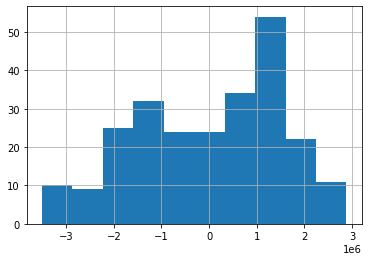

In [228]:
#pandas has some basic graphing built in
def histogram_region(region):
    df[df['Region']==region]['propane injection'].hist()
    print(region)

histogram_region('Canada')

In [229]:
#describe: Can be used on one column or the entire dataset
df[df['Region']=='Canada']['propane injection'].describe()
df[df['Region']=='Canada'].describe()

,index,Spec. propane,Total butane,Normal butane,Iso-butane,Total mix,C2 in mix,C3 in mix,C4 in mix,Other in mix,propane injection
count,2.460000e+02,2.460000e+02,2.460000e+02,0.0,0.0,2.460000e+02,2.460000e+02,2.460000e+02,2.460000e+02,246.000000,2.450000e+02
mean,7.705005e+05,6.538987e+06,4.124072e+06,NaN,NaN,4.189600e+06,4.514807e+05,1.995081e+06,1.306740e+06,436298.589953,7.091957e+03
std,4.475713e+05,2.990115e+06,1.632511e+06,NaN,NaN,1.119407e+06,1.695562e+05,5.601395e+05,3.793950e+05,122830.640323,1.524949e+06
min,0.000000e+00,7.830424e+05,8.708641e+05,NaN,NaN,2.020989e+06,0.000000e+00,9.791622e+05,6.553771e+05,181569.797098,-3.506738e+06
25%,3.852502e+05,4.108757e+06,2.962156e+06,NaN,NaN,3.366134e+06,3.329656e+05,1.554303e+06,1.014076e+06,343903.610644,-1.188275e+06
50%,7.705005e+05,6.577026e+06,4.028230e+06,NaN,NaN,4.099133e+06,4.434201e+05,1.935704e+06,1.261215e+06,429579.003471,3.129553e+05
75%,1.155751e+06,9.038121e+06,5.120460e+06,NaN,NaN,4.876605e+06,5.515298e+05,2.358861e+06,1.544354e+06,520149.922873,1.205024e+06
max,1.541001e+06,1.210208e+07,9.571377e+06,NaN,NaN,7.530774e+06,1.174764e+06,3.752394e+06,2.488855e+06,750052.548894,2.881569e+06


In [230]:
#matplotlib offers better customization compared to basic pandas charts
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

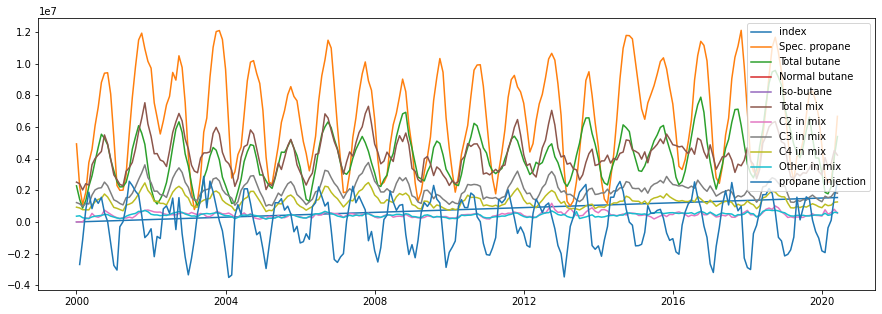

In [231]:
fig, ax = plt.subplots(figsize=(15, 5))
df_plot = df[df['Region']=='Canada'].copy().set_index('Date')
del df_plot['Region']
ax.plot(df_plot)
ax.legend(df_plot.columns)

No handles with labels found to put in legend.


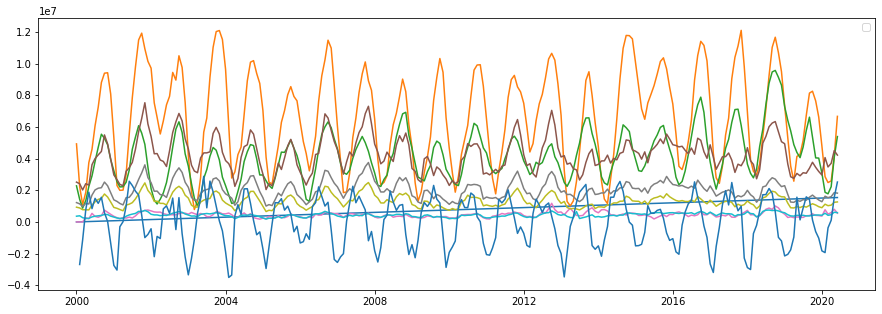

In [232]:
## Iterate through the columns to draw each
fig, ax = plt.subplots(figsize=(15, 5))
for i in range(df_plot.shape[1]):
    #if...
    ax.plot(df_plot.iloc[:,i])
ax.legend()

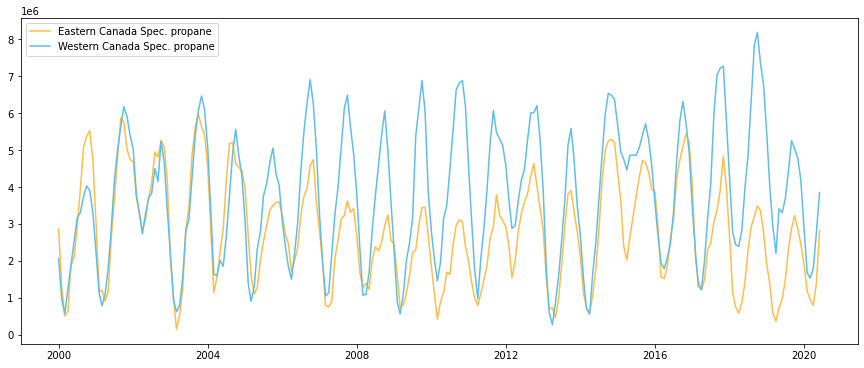

In [233]:
CER = ['#054169','#FFBE4B','#5FBEE6','#559B37','#FF821E','#871455','#FFFFFF','#8c8c96','#42464B']

fig, ax = plt.subplots(figsize=(15, 6))

i = 0
for r in df['Region'].unique():
    if r != 'Canada':
        ax.plot(df[df['Region']==r]['Date'], df[df['Region']==r]['Spec. propane'],label=r+' Spec. propane',color=CER[i])
    i = i+1
ax.legend()

#Note, we didnt need to merge eastern and western canada spec propane columns to make this happen (but this would work as well)

## Data Analysis Example: How can you get the five year average propane injections for a given region (Eastern Canada) ?

Note - with heating commodities, the five year average is used to compare the current years statistics with the previous five years. So the current five year average would include 2015 - 2019 (inclusive)


If you cant remember the exact code/functions to use, start writing down the steps that could make this happen.

In [234]:
region = 'Eastern Canada'

In [235]:
df5 = df[df['Region']==region][['Date','propane injection']]
#df5['Year'] = [x.year for x in df5['Date']]
max_date = df5['Date'].max() 
max_date

Timestamp('2020-06-01 00:00:00')

In [236]:
max_year = max_date - relativedelta.relativedelta(years = 1)
max_year = max_year.year
max_year

2019

In [237]:
min_year = max_year - 4
min_year

2015

In [238]:
df5 = df5[(df5['Date'].dt.year <= max_year) & (df5['Date'].dt.year >= min_year)]

In [239]:
df5.head()
df5.tail()

,Date,propane injection
481,2019-08-01,841944.45126
482,2019-09-01,569740.14768
483,2019-10-01,341411.60196
484,2019-11-01,-354374.25078
485,2019-12-01,-425030.71908


In [240]:
df5 = df5.groupby(df['Date'].dt.month).mean()
df5

,propane injection
Date,
1,-8.370005e+05
2,-1.157486e+06
3,-8.716660e+05
4,-2.075801e+05
5,3.723268e+05
6,5.875379e+05
7,5.149443e+05
8,7.396664e+05
9,4.232434e+05


In [241]:
import os.path
def five_year_avg(df, region='Eastern Canada', save=True):
    
    #isolate the data for the given region
    df5 = df[df['Region']==region][['Date','propane injection']]
    #get the max and min years for the analysis
    max_date = df5['Date'].max()
    max_year = max_date - relativedelta.relativedelta(years = 1)
    max_year = max_year.year
    min_year = max_year - 5
    #filter the dataframe on two conditions using the "AND" operator
    df5 = df5[(df5['Date'].dt.year <= max_year) & (df5['Date'].dt.year > min_year)]
    df5 = df5.groupby(df['Date'].dt.month).mean()
    #new code to compare the 2020 injections/withdrawls from the average
    
    current_year = max(df[df['Region']==region]['Date'].dt.year)
    df_now = df[(df['Region']==region) & (df['Date'].dt.year == current_year)].copy()
    df_now['Month'] = df_now['Date'].dt.month
    df_now = df_now[['Month','propane injection']]
    
    df5 = df5.merge(df_now,how='left',left_on='Date',right_on='Month',suffixes=('_avg','_now'))
    del df5['Month']
    
    if save and not os.path.isfile(region+'.csv'):
        df5.to_csv(region+'.csv')
    
    print(region)
    df5.plot()
    return df5

Eastern Canada


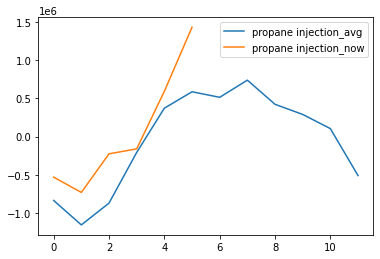

In [242]:
df5 = five_year_avg(df,region = 'Eastern Canada')

## Appendix: data scraping

We do alot of data scraping at the CER. This is how we populate the CERSEI database.

Some websites are easier to scrape than others...

How can we scape the LPG data?

In [243]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [244]:
link = 'https://www.cer-rec.gc.ca/nrg/sttstc/ntrlgslqds/stt/2020lqdptrlmgs.xlsx'
df_scrape = pd.read_excel(link,sheet_name='Data')
#can anyone see an issue with this link?

ValueError: File is not a recognized excel file

In [ ]:
df_scrape.head()

In [ ]:
dynamic_link = link.split('/')
dynamic_link[-1][4:]

now = datetime.date.today()
now.year

dynamic_link[-1] = str(now.year)+dynamic_link[-1][4:]
dynamic_link = '/'.join(dynamic_link)
dynamic_link

In [ ]:
#other modules used for webscraping
import selenium
from bs4 import BeautifulSoup
import requests

# How can we consolidate this data analysis example?

Modular code...

In [ ]:
def english_only(arr):
    return {x:x.split('/')[0].strip() for x in arr}
    
    
def scrape_data(link='https://www.cer-rec.gc.ca/nrg/sttstc/ntrlgslqds/stt/2020lqdptrlmgs.xlsx'):
    dynamic_link = link.split('/')
    dynamic_link[-1][4:]

    now = datetime.date.today()
    now.year
    dynamic_link[-1] = str(now.year)+dynamic_link[-1][4:]
    dynamic_link = '/'.join(dynamic_link)
    df = pd.read_excel(link,sheet_name='Data')
    
    return df


def process_data(df = scrape_data()):
    
    new_columns = english_only(df.columns)
    df = df.rename(columns=new_columns)
    
    new_regions = english_only(df['Region'].unique())
    df['Region'] = df['Region'].replace(new_regions)
    
    return df
    

def calculate_injections(df):
    
    new_group = []
    for r in df['Region'].unique():
        df_r = df[df['Region']==r].copy()
        df_r = df_r.sort_values(by=['Date'])
        df_r['propane injection'] = df_r['Spec. propane'] - df_r['Spec. propane'].shift(1)
        new_group.append(df_r)
    df = pd.concat(new_group, ignore_index=True)
    
    return df


def five_year_avg(region='Eastern Canada', save=True):
    df = process_data()
    df = calculate_injections(df)
    #isolate the data for the given region
    df5 = df[df['Region']==region][['Date','propane injection']].copy()
    #get the max and min years for the analysis
    max_date = df5['Date'].max()
    max_year = max_date - relativedelta.relativedelta(years = 1)
    max_year = max_year.year
    min_year = max_year - 4
    #filter the dataframe on two conditions using the "AND" operator
    df5 = df5[(df5['Date'].dt.year <= max_year) & (df5['Date'].dt.year >= min_year)]
    df5 = df5.groupby(df['Date'].dt.month).mean()
    #new code to compare the 2020 injections/withdrawls from the average
    
    current_year = max(df[df['Region']==region]['Date'].dt.year)
    df_now = df[(df['Region']==region) & (df['Date'].dt.year == current_year)].copy()
    df_now['Month'] = df_now['Date'].dt.month
    df_now = df_now[['Month','propane injection']]
    
    df5 = df5.merge(df_now,how='left',left_on='Date',right_on='Month',suffixes=('_avg','_now'))
    del df5['Month']
    
    if save and not os.path.isfile(region+'.csv'):
        df5.to_csv(region+'.csv')
    
    print(region+' '+str(current_year))
    df5.plot()

In [ ]:
five_year_avg(region='Eastern Canada',save=False)

### Homework...

How can we modify the code so that the product (Spec. propane, total butane) can be passed into the functions to change which product is displayed in the graph?

### Final Notes:

1) This is a process. Once you get over the "hump" you'll start to find that writing python for your job is easier and faster than using excell for complicated problems.

2) Even if you aern't comfortable with the basics yet, start forcing yourself to do projects in python as opposed to excel.

3) If you feel like putting your fist through the computer screen, that means you are learning...